In [1]:
import pandas as pd
import json
import numpy as np
from collections import Counter
import re

In [8]:
df = pd.read_csv("data_travaux/travaux-engages-metropole-lyon.csv", sep=";")
print(df.describe())
display(df)

             numero    code_insee            gid
count  1.319000e+03   1319.000000    1319.000000
mean   2.024778e+08  69258.603487  195480.064443
std    9.287741e+04    121.778735   10836.950822
min    2.018121e+08  69003.000000   74592.000000
25%    2.025078e+08  69157.500000  196242.500000
50%    2.025110e+08  69271.000000  198649.000000
75%    2.025124e+08  69383.000000  199952.500000
max    2.025134e+08  69389.000000  200753.000000


,numero,intervenant,nature_chantier,nature_travaux,etat,date_debut,date_fin,mesures_police,last_update,adresse,commune,code_insee,contact_tel,contact_mail,contact_url,gid
0,202206858,LYON - Direction De La Construction,Travaux sur une parcelle en limite d'espace pu...,Renfort chaussée en vue de la pose d'une grue,Ouvert,2024-06-03,2028-12-31,NaN,2025-02-07 09:02:15.051362+01:00,"10 rue Neyret, 69001 Rue des Tables Claudienn...",Lyon 1er,69381,NaN,NaN,NaN,183025
1,202512731,ORANGE SA,"Branchements réseau < 25 ml TELECOM, RMT ET VIDEO","Intervention sur des chambres, boites, armoire...",Validé,2025-12-24,2026-01-07,"Circulation alternée, Restriction de jour",2025-12-16 15:02:03.127680+01:00,Face au 10 Route du Bruissin (Francheville),Francheville,69089,NaN,NaN,NaN,199942
2,202512882,DCE / RT / Rive Gauche,Émergences et autres équipements d'assainissement,Remise à niveau / entretien des tampons et éme...,Validé,2025-12-15,2026-01-16,NaN,2025-12-04 12:02:37.539147+01:00,"Avenue d'Oschatz, de Rue Gaston Monmousseau a...",Venissieux,69259,04 28 67 55 00,NaN,NaN,199946
3,202512887,ORANGE SA,"Branchements réseau < 25 ml TELECOM, RMT ET VIDEO",Réparation de branchement < 25 ml (télécom ou ...,Validé,2025-12-12,2026-01-19,NaN,2025-12-04 12:02:38.122193+01:00,à côté 3 Chemin de Chantegrillet (Francheville),Francheville,69089,NaN,NaN,NaN,199947
4,202513013,DCE / RT / Rive Droite Sud,"Construction, renouvellement et réparation rés...",Réparation de canalisation d'assainissement,Validé,2025-12-08,2025-12-19,NaN,2025-12-04 12:02:38.969904+01:00,35 Rue Pierre Dupont (Lyon 1er Arrondissement),Lyon 1er,69381,04 28 67 55 20,NaN,NaN,199954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,202512873,RCU Centre Métropole - ELM (Dalkia),"Construction, renouvellement et réparation rés...",Construction de réseau sans branchement (Chauf...,Validé,2025-12-02,2025-12-24,NaN,2025-12-16 15:02:03.235650+01:00,"Du 16 Rue du 8 Mai 1945, au 104 Place du 8 Mai...",Saint Priest,69290,NaN,NaN,NaN,199822
1315,202301053,AOMTL (SYTRAL Mobilités),Aménagement pour les transports en commun,Création / aménagement de voie Bus / Tram,Ouvert,2023-02-07,2026-08-31,NaN,2023-02-07 18:07:40.672980+01:00,- Rue Rue Florian (Villeurbanne) : De Avenue A...,Villeurbanne,69266,NaN,NaN,NaN,135907
1316,202301060,AOMTL (SYTRAL Mobilités),Aménagement pour les transports en commun,Création / aménagement de voie Bus / Tram,Ouvert,2023-01-23,2026-08-31,NaN,2023-02-07 18:07:10.246549+01:00,Tracé T6N du carrefour Zola/Verlaine Bourgey a...,Villeurbanne,69266,NaN,NaN,NaN,135939
1317,202301064,AOMTL (SYTRAL Mobilités),Aménagement pour les transports en commun,Création / aménagement de voie Bus / Tram,Ouvert,2023-01-23,2026-08-31,NaN,2023-02-07 18:07:31.539607+01:00,Traversée futur Parc - Usine ACI Villeurbanne ...,Villeurbanne,69266,NaN,NaN,NaN,135921


In [ ]:
# --- 1. GÉNÉRATION DU FICHIER POINTS ROUGES (Coordonnées + Description) ---

with open('data_coord/points-rouges-200046977.geojson', 'r') as f:
    geojson_data = json.load(f)

# Extraction des coordonnées (longitude, latitude) et des propriétés
points_rouges_data = []
for feature in geojson_data['features']:
    props = feature['properties']
    coords = feature['geometry']['coordinates']
    
    points_rouges_data.append({
        'longitude': coords[0],
        'latitude': coords[1],
        'commune_insee': props.get('commune'), 
        'description': props.get('description') 
    })

df_points_rouges_final = pd.DataFrame(points_rouges_data)

# Sauvegarde du premier fichier
df_points_rouges_final.to_csv('points_rouges_lyon_complet.csv', index=False)


# --- 2. GÉNÉRATION DU FICHIER RÉPONSES (Questionnaire + Lieu) ---

# Chargement du CSV original
df_reponses = pd.read_csv('data_coord/reponses-epci-200046977.csv', low_memory=False, quotechar='"')

# Sélection des colonnes stratégiques selon la notice [cite: 86, 88, 90]
cols_reponses = [
    'insee',        # Lieu (Code INSEE) [cite: 21, 29]
    'q6',           # Fréquence de pratique [cite: 86]
    'q14',          # Sentiment de sécurité [cite: 86]
    'q18',          # Dangerosité carrefours [cite: 88]
    'q21',          # État de l'entretien [cite: 88]
    'q28',          # Conflit stationnement motorisé [cite: 88]
    'q34_texte',    # Les 3 priorités d'amélioration [cite: 88]
    'q35',          # Commentaire libre (NLP) [cite: 88]
    'q38_texte',    # Situations de violence vécues [cite: 90]
    'score'         # Note globale de la commune [cite: 30]
]

# Filtrage et nettoyage
df_reponses_final = df_reponses[cols_reponses].copy()
df_reponses_final['q35'] = df_reponses_final['q35'].str.replace(r'\r+|\n+', ' ', regex=True).fillna('')

# Sauvegarde du second fichier
df_reponses_final.to_csv('reponses_questionnaire_lyon.csv', index=False)

print("Les deux fichiers ont été générés avec succès :")
print("- points_rouges_lyon_complet.csv (Données cartographiques)")
print("- reponses_questionnaire_lyon.csv (Données thématiques et profils)")

Les deux fichiers ont été générés avec succès :
- points_rouges_lyon_complet.csv (Données cartographiques)
- reponses_questionnaire_lyon.csv (Données thématiques et profils)


### SPARK

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, StringType
import pandas as pd
import re

# 1. INITIALISATION DE LA SESSION
spark = SparkSession.builder.appName("Datathon_Lyon_Complet").getOrCreate()

# 2. CONFIGURATION RÉFÉRENTIELLE
CONFIG_PROBLEMES = {
    'Infrastructure manquante': {'mots': r'piste|manque|absence|discontinuité|coupure', 'urgence': 3, 'facilite': 3},
    'Carrefours dangereux': {'mots': r'carrefour|intersection|rond-point|traversée', 'urgence': 3, 'facilite': 3},
    'Vitesse excessive': {'mots': r'vitesse|rapide|trop vite|ralentir', 'urgence': 3, 'facilite': 2},
    'Violence routière': {'mots': r'violence|insulte|intimidation|agression', 'urgence': 3, 'facilite': 2},
    'Entretien pistes': {'mots': r'entretien|entretenir|nid de poule|trou|verre', 'urgence': 2, 'facilite': 1},
    'Stationnement gênant': {'mots': r'stationnement|garé|voiture|parking|double file', 'urgence': 2, 'facilite': 2},
    'Stationnement vélo': {'mots': r'stationnement vélo|parking vélo|garage vélo', 'urgence': 2, 'facilite': 1},
    'Limitation trafic': {'mots': r'limiter trafic|réduire trafic|moins de voiture', 'urgence': 2, 'facilite': 3},
    'Signalisation': {'mots': r'panneau|feu|signalisation|marquage', 'urgence': 1, 'facilite': 1},
    'Conflit piétons': {'mots': r'piéton|trottoir|partagé|quai', 'urgence': 1, 'facilite': 2},
}

def get_label_facilite(score):
    if score <= 1.5: return "🟢 Facile"
    if score <= 2.5: return "🟡 Moyen"
    return "🔴 Difficile"

# Partage de la config sur le cluster
conf_broadcast = spark.sparkContext.broadcast(CONFIG_PROBLEMES)

# 3. FONCTION DE DÉTECTION (UDF)
def detecter_themes_py(texte):
    if texte is None or texte == "": return []
    res = []
    for nom, cfg in conf_broadcast.value.items():
        if re.search(cfg['mots'], str(texte).lower()):
            res.append(nom)
    return res

detecter_themes_udf = F.udf(detecter_themes_py, ArrayType(StringType()))

# 4. CHARGEMENT ET NETTOYAGE ROBUSTE
print("Chargement des données...")
# On utilise multiLine et quote pour éviter que les commentaires ne cassent les colonnes
df_raw = spark.read.option("header", "true").option("multiLine", "true").option("quote", "\"").option("escape", "\"").csv('reponses_questionnaire_lyon.csv')

# Filtre : On ne garde que les codes INSEE valides (5 chiffres) pour éviter les décalages de texte
df_clean = df_raw.filter(F.col("insee").rlike("^[0-9]{5}$"))

# Cast de la sécurité (q14) : les textes deviennent NULL proprement
df_spark = df_clean.withColumn("q14", F.expr("try_cast(q14 as double)"))

# Fusion des textes pour analyse
df_processed = df_spark.withColumn(
    'verbatim', 
    F.concat_ws(' ', F.coalesce(F.col('q34_texte'), F.lit('')), 
                     F.coalesce(F.col('q35'), F.lit('')), 
                     F.coalesce(F.col('q38_texte'), F.lit('')))
).withColumn('problemes_list', detecter_themes_udf(F.col('verbatim')))

# 5. ANALYSE PAR TYPE DE PROBLÈME (GLOBAL)
print("\n ANALYSE DE LA FACILITÉ PAR TYPE DE PROBLÈME")
df_exploded = df_processed.select(F.explode("problemes_list").alias("probleme"))
counts_global = {row['probleme']: row['count'] for row in df_exploded.groupBy("probleme").count().collect()}

analyse_p = []
for nom, cfg in CONFIG_PROBLEMES.items():
    analyse_p.append({
        'Problème': nom,
        'Citations': counts_global.get(nom, 0),
        'Urgence': cfg['urgence'],
        'Facilité': cfg['facilite'],
        'Type': get_label_facilite(cfg['facilite'])
    })

df_facilite_theme = pd.DataFrame(analyse_p).sort_values(by='Facilité')
print(df_facilite_theme.to_string(index=False))

# 6. ANALYSE PAR COMMUNE (TOP 10)
print("\n ANALYSE PAR COMMUNE (TOP 10)")

# Sécurité Moyenne
df_secu = df_processed.groupBy("insee").agg(
    F.count("*").alias("Réponses"),
    F.round(F.avg("q14"), 2).alias("Sécurité_Moy")
)

# Calcul du Top 10 des thèmes par commune
df_exploded_commune = df_processed.select("insee", F.explode("problemes_list").alias("probleme"))
df_counts_commune = df_exploded_commune.groupBy("insee", "probleme").count()

window_spec = Window.partitionBy("insee").orderBy(F.col("count").desc())
df_ranked = df_counts_commune.withColumn("rank", F.row_number().over(window_spec)) \
    .filter(F.col("rank") <= 10) \
    .withColumn("p_fmt", F.concat(F.col("probleme"), F.lit(" ("), F.col("count"), F.lit(")")))

df_top10 = df_ranked.groupBy("insee").agg(F.concat_ws(" | ", F.collect_list("p_fmt")).alias("Top_10_Problemes"))

# 7. EXPORT FINAL
df_final = df_secu.join(df_top10, "insee", "left").orderBy(F.col("Réponses").desc())
result_pandas = df_final.toPandas()
result_pandas.to_csv("analyse_finale_lyon_spark.csv", index=False)

print("\n" + "="*120)
print(result_pandas.head(15).to_string(index=False))
print("="*120)

In [11]:
!pip install geopandas
!pip install osmnx geopandas
!pip install scipy scikit-learn
!pip install pyspark
!pip install pyarrow	

  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached pyogrio-0.12.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached pyproj-3.7.2-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (31 kB)
  Using cached shapely-2.1.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.8 kB)
  Using cached certifi-2025.11.12-py3-none-any.whl.metadata (2.5 kB)
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
Using cached pyogrio-0.12.1-cp312-cp312-manylinux_2_28_x86_64.whl (32.5 MB)
Using cached pyproj-3.7.2-cp312-cp312-manylinux_2_28_x86_64.whl (9.6 MB)
Using cached shapely-2.1.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.1 MB)
Using cached certifi-2025.11.12-py3-none-any.whl (159 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [geopandas]/5 [geopandas]
  Using cached osmnx-2.0.7-py3-none-any.whl.metadata (4.9 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached requests-2.32.5-p

In [13]:
import geopandas as gpd
from shapely.geometry import Point

# 1. Lecture du fichier CSV avec Pandas
file_path = "points_rouges_lyon_complet.csv"
df = pd.read_csv(file_path)

# 2. Conversion du DataFrame en GeoDataFrame
# On crée la colonne 'geometry' à partir des colonnes longitude et latitude
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"  # Système de coordonnées standard (WGS84)
)

# Affichage des premières lignes
print(f"Nombre de lignes : {len(gdf)}")
print(f"Type de géométrie : {gdf.geometry.type.unique()}")
display(gdf.head())

Nombre de lignes : 24256
Type de géométrie : ['Point']


,longitude,latitude,commune_insee,description,geometry
0,4.836445,45.758438,69123,NaN,POINT (4.83645 45.75844)
1,4.859543,45.731105,69123,NaN,POINT (4.85954 45.7311)
2,4.833717,45.731325,69123,NaN,POINT (4.83372 45.73133)
3,4.867707,45.729358,69123,NaN,POINT (4.86771 45.72936)
4,4.797329,45.803997,69194,Éboulement,POINT (4.79733 45.804)


In [ ]:
import osmnx as ox
import geopandas as gpd
import pandas as pd

# 1. Charger le réseau routier de Lyon
# "drive" récupère toutes les rues carrossables
G = ox.graph_from_place("Lyon, France", network_type="drive")

# 2. Projeter le graphe en mètres (UTM) pour un calcul de distance précis
G_proj = ox.project_graph(G)

# 3. Préparer vos données (gdf) 
# On s'assure qu'elles sont dans le même système de coordonnées que le graphe projeté
gdf_proj = gdf.to_crs(G_proj.graph['crs'])

# 4. Trouver l'arête (rue) la plus proche pour chaque point
# ox.nearest_edges renvoie l'ID de la rue (u, v, key)
nearest_edges = ox.nearest_edges(G_proj, X=gdf_proj.geometry.x, Y=gdf_proj.geometry.y)

# 5. Calculer le point exact sur la rue (projection orthogonale)
# On utilise la fonction interpolate sur la géométrie de la rue
edges = ox.graph_to_gdfs(G_proj, nodes=False)
projected_points = []

for i, (point, edge_id) in enumerate(zip(gdf_proj.geometry, nearest_edges)):
    # Récupérer la ligne (geometry) de la rue correspondante
    street_line = edges.loc[edge_id, 'geometry']
    # Trouver le point sur cette ligne le plus proche de notre point d'origine
    snap_point = street_line.interpolate(street_line.project(point))
    projected_points.append(snap_point)

# 6. Créer un GeoDataFrame temporaire pour convertir les points projetés en Lat/Lon
snapped_gdf = gpd.GeoDataFrame(geometry=projected_points, crs=G_proj.graph['crs'])
snapped_gdf = snapped_gdf.to_crs(epsg=4326) # Retour en format GPS standard

# 7. Ajouter les colonnes au DataFrame d'origine
gdf['longitude_modified'] = snapped_gdf.geometry.x
gdf['latitude_modified'] = snapped_gdf.geometry.y

# Affichage des résultats
display(gdf[['longitude_modified', 'latitude_modified']].head())

,longitude_modified,latitude_modified
0,4.837045,45.758318
1,4.859541,45.731103
2,4.833732,45.731342
3,4.867713,45.729350
4,4.796513,45.791578


In [6]:
!pip install matplotlib
!pip install seaborn

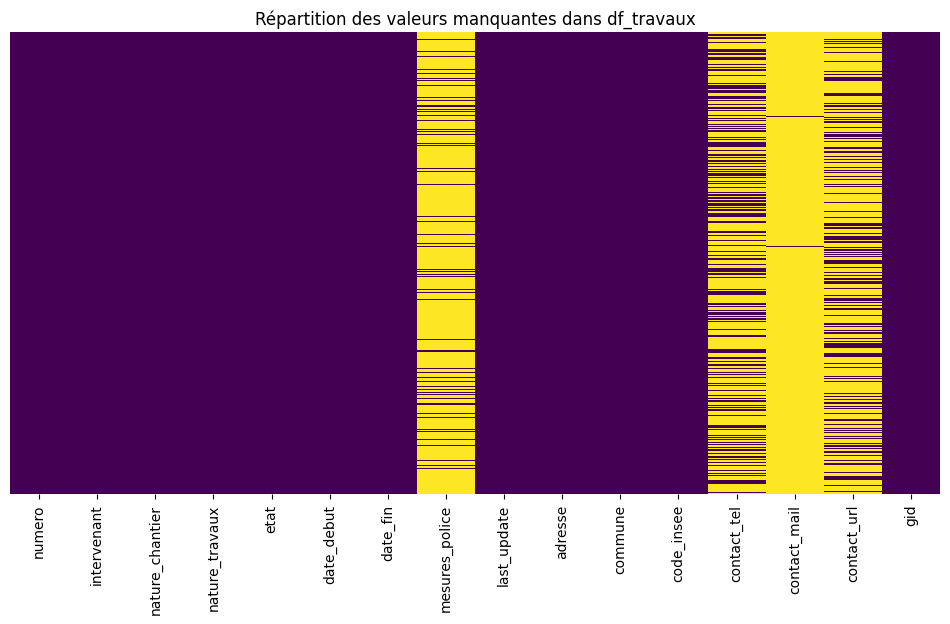

In [7]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
# Charger le dataframe du dataset des travaux engagés à Lyon
df_travaux = pd.read_csv("data_travaux/travaux-engages-metropole-lyon.csv", sep=";")
# Visualisation des valeurs manquantes dans df_travaux
plt.figure(figsize=(12, 6))
sns.heatmap(df_travaux.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Répartition des valeurs manquantes dans df_travaux')
plt.show()

In [8]:
cols_travaux_a_supprimer = ['mesures_police', 'contact_tel', 'contact_mail', 'contact_url'] # Trop de NaN dans les colonnes
df_travaux = df_travaux.drop(columns=cols_travaux_a_supprimer, errors='ignore')

In [9]:
print("--- Valeurs manquantes dans df_travaux ---")
print(df_travaux.isnull().sum())

# Supprime les lignes où 'date_debut' est NaN
df_travaux = df_travaux.dropna(subset=['date_debut'])

--- Valeurs manquantes dans df_travaux ---
numero             0
intervenant        0
nature_chantier    0
nature_travaux     0
etat               0
date_debut         3
date_fin           0
last_update        0
adresse            0
commune            0
code_insee         0
gid                0
dtype: int64


In [11]:
df_flux = pd.read_csv("data_flux/mesures-comptage-metropole-lyon.csv", sep=';')


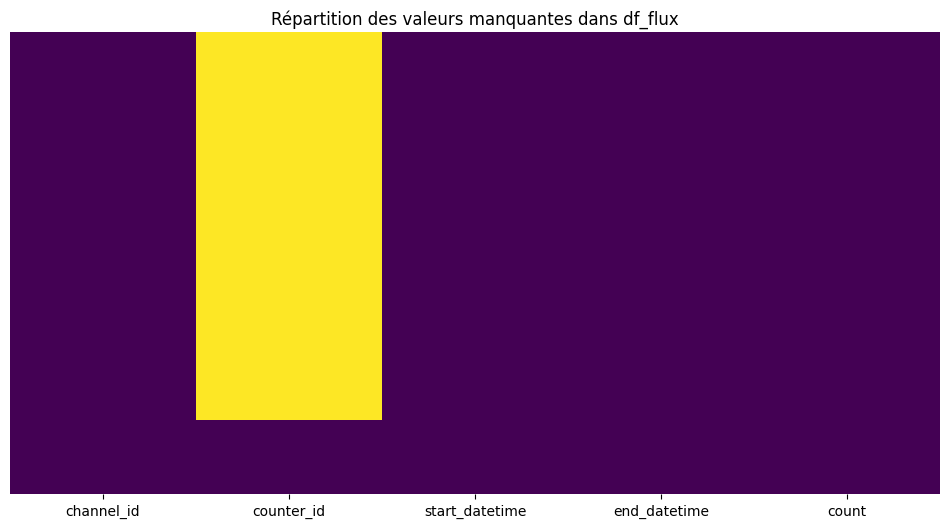

In [12]:
# Visualisation des valeurs manquantes dans df_flux
plt.figure(figsize=(12, 6))
sns.heatmap(df_flux.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Répartition des valeurs manquantes dans df_flux')
plt.show()

In [13]:
# Suppression de la colonne 'counter_id' 
df_flux = df_flux.drop(columns="counter_id", errors='ignore')

